# Simulacion Historica de Portafolios
El objectivo de este ejercicio es construir una simulacion historica 

<AxesSubplot:xlabel='date'>

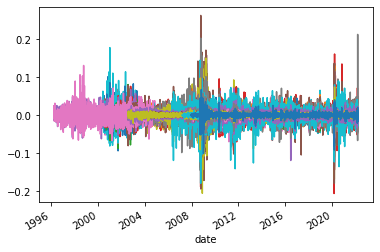

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Importar nuestra data
meta = pd.read_csv('etf_list.csv')
meta = meta.set_index('ticker')
rt_etf = pd.read_pickle('etf_er.pkl')
rt_etf.columns = [meta.loc[nemo, 'aesthetic'] for nemo in rt_etf.columns]

rt_etf.plot(legend=False)

### 1. Funciones Basicas
- Retorno de portafolio
- Volatilidad

In [10]:
def retorno_portafolio(w, mu):
    ret_p = w.reshape(-1, 1).T @ mu.reshape(-1, 1)
    return ret_p.item()

def volatilidad_portafolio(w, sigma):
    var_p = w.reshape(-1, 1).T @ sigma @ w.reshape(-1, 1)
    vol_p = np.sqrt(var_p)
    return vol_p.item()

def sharpe_ratio(w, mu, sigma, rf=0):
    ret_p = retorno_portafolio(w, mu)
    vol_p = volatilidad_portafolio(w, sigma)
    sr = (ret_p - rf) / vol_p
    return sr

### 2. Optimizando un portafolio
Probando la optimizacion antes del espectaculo principal

#### 2.1 Parametros

In [23]:
window = pd.DateOffset(years=5)  # Largo de la ventana de estimacion
dt = datetime(2021, 12, 31)  # Fecha de rebalanceo de prueba

muestra = rt_etf.loc[dt - window:dt]
n = muestra.shape[1]  # Numero de columnas
mu = muestra.mean().values * 252  # Vector de retornos
sigma = muestra.cov().values * 252  # Matriz de varianzas-covarianzas
w0 = np.array([1 / n] * n)  # Punto inicial

#### 2.2 Portafolio de minima varianza (sin restricciones)

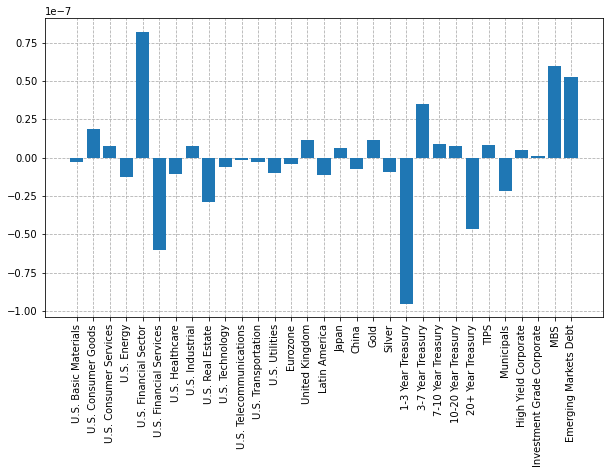

In [42]:
opt = minimize(
    fun=volatilidad_portafolio,
    x0=w0,
    args=[sigma]
)

w_mv = opt.x  # Solucion de minima varianza

# Veamos como se ven los resultados
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.bar(x=muestra.columns, height=w_mv, zorder=100)
plt.xticks(rotation=90)
ax.grid(ls='--', zorder=-99)
plt.show()

#### 2.3 Aplicando restricciones a la optimizacion

\begin{equation}
  \begin{aligned}
  \operatorname*{argmin}_{\boldsymbol{w}} & \hskip 1em \frac{1}{2} \boldsymbol{w}^{T} \boldsymbol{\Sigma} \boldsymbol{w}\\
  \text{s.t.} & \hskip 1em \forall \boldsymbol{x} \geq 0\\
  & \hskip 1em \boldsymbol{x}^{T} \boldsymbol{w} = 1 \\
  \end{aligned}
\end{equation}

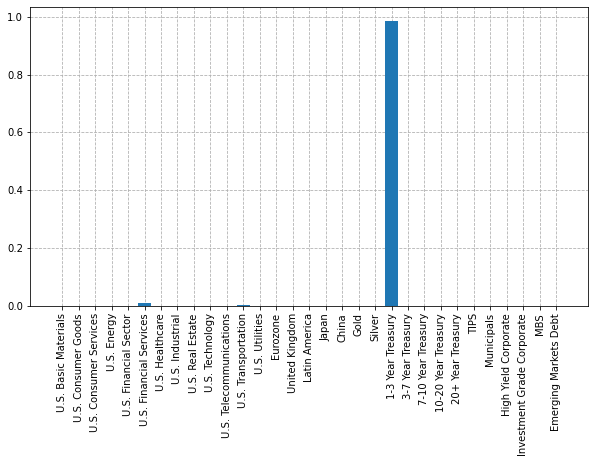

In [64]:
restricciones = (
    {'type': 'ineq', 'fun': lambda x:  x},  # No ventas cortas
    {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}  # Capital 100% invertido
)

opt = minimize(
    fun=volatilidad_portafolio,
    x0=w0,
    args=[sigma],
    constraints=restricciones
)

w_mv = opt.x  # Solucion de minima varianza

# Veamos como se ven los resultados
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.bar(x=muestra.columns, height=w_mv, zorder=100)
plt.xticks(rotation=90)
ax.grid(ls='--', zorder=-99)
plt.show()

### 3. Backtesting

In [ ]:
bt_start = datetime(2001, 12, 31)
bt_end = datetime(2001, 12, 31)
pd.date_range(bt_start, bt_end)